In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))



Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [ ]:
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json



In [ ]:

!kaggle datasets download -d emmarex/plantdisease


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 99% 653M/658M [00:17<00:00, 38.0MB/s]
100% 658M/658M [00:17<00:00, 39.4MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "/content/plantdisease.zip" # Changed the file name to the correct one.
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import os
import shutil

# Set the path to the dataset directory
dataset_dir = "/content/PlantVillage"

# List all directories in the dataset
directories = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]

# Specify the directories you want to delete (all paths should be relative to dataset_dir)
directories_to_delete = [
    "Pepper__bell___Bacterial_spot",
    "Pepper__bell___healthy",
    "Tomato_Bacterial_spot",
    "Tomato_Early_blight",
    "Tomato_Late_blight",
    "Tomato_Leaf_Mold",
    "Tomato_Septoria_leaf_spot",
    "Tomato_Spider_mites_Two_spotted_spider_mite",
    "Tomato__Target_Spot",
    "Tomato__Tomato_YellowLeaf__Curl_Virus",
    "Tomato__Tomato_mosaic_virus",
    "Tomato_healthy"
]

# Iterate over the directories and delete them along with their contents
for directory in directories_to_delete:
    directory_path = os.path.join(dataset_dir, directory)
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)
        print(f"Deleted directory: {directory_path}")
    else:
        print(f"Directory not found: {directory_path}")


Deleted directory: /content/PlantVillage/Pepper__bell___Bacterial_spot
Deleted directory: /content/PlantVillage/Pepper__bell___healthy
Deleted directory: /content/PlantVillage/Tomato_Bacterial_spot
Deleted directory: /content/PlantVillage/Tomato_Early_blight
Deleted directory: /content/PlantVillage/Tomato_Late_blight
Deleted directory: /content/PlantVillage/Tomato_Leaf_Mold
Deleted directory: /content/PlantVillage/Tomato_Septoria_leaf_spot
Deleted directory: /content/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite
Deleted directory: /content/PlantVillage/Tomato__Target_Spot
Deleted directory: /content/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus
Deleted directory: /content/PlantVillage/Tomato__Tomato_mosaic_virus
Deleted directory: /content/PlantVillage/Tomato_healthy



# **Directories & Classes**<br>
These are the path of the dataset innter folders and classes in the given dataset

In [ ]:
DIRECTORY = r'/content/'
FOLDERS = ['PlantVillage']
CLASSES = ['Tomato_healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Leaf_Mold',
 'Tomato_Bacterial_spot',
 'Tomato_Late_blight',
 'Tomato_Early_blight',
 'Tomato__Tomato_YellowLeaf__Curl_Virus']


**Load Data**<br>
the given code is loading the training and validation data from the dataset and convert these images to array with the size of 150x150 and append each image datain train_data, and val_data list. I have loaded just 2500 images from eaach class due to limitted resources.

In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
classes_names=dataset.class_names
classes_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

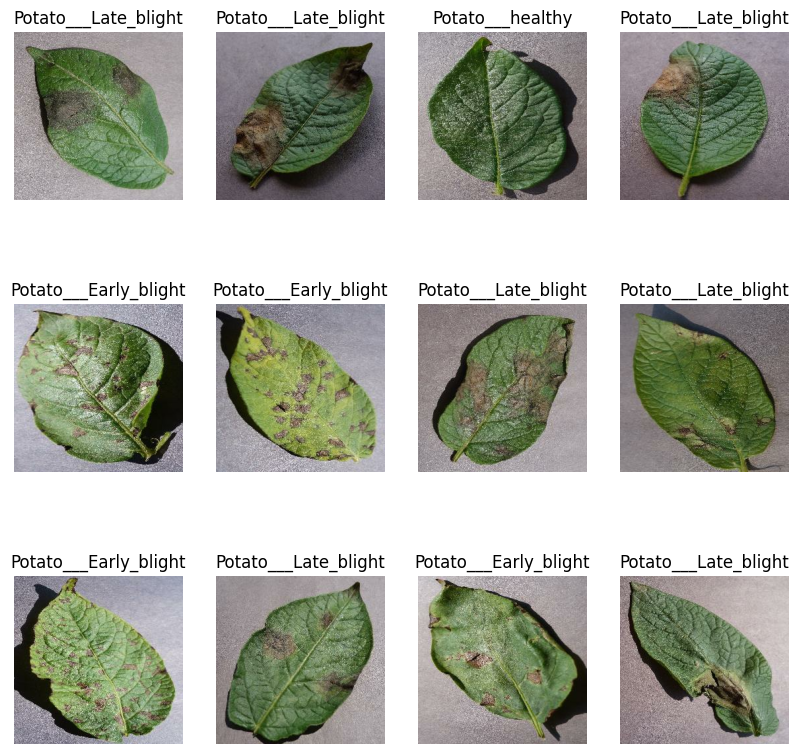

In [ ]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(classes_names[label_batch[i]])
    plt.axis("off")

**Train Test Split**


*   80% training data
*   20% test but 10% are validation and 10% are test



In [ ]:
def get_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
 ds_size=len(ds)
 if shuffle:
  ds=ds.shuffle(shuffle_size,seed=12)

 train_data=int(train_split*ds_size)
 val_data=int(val_split*ds_size)

 train_ds=ds.take(train_data)
 val_ds=ds.skip(train_data).take(val_data)
 test_ds=ds.skip(train_data).skip(val_data)

 return train_ds,val_ds,test_ds

In [ ]:

train_ds,val_ds,test_ds=get_partition_tf(dataset)

In [ ]:
len(train_ds)


54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

In [ ]:
# Prefetch is a technique used to improve data loading speed by preparing data for the next step while the current step is still running.
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
Data_Augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

**Model Building**

In [ ]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model= models.Sequential([
    resize_and_rescale,
    Data_Augmentation,
    layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(len(classes_names),activation="softmax")
])

In [ ]:
model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [ ]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
54/54 [==============================] - 15s 106ms/step - loss: 0.8115 - accuracy: 0.5689 - val_loss: 0.6122 - val_accuracy: 0.7448
Epoch 2/20
54/54 [==============================] - 3s 62ms/step - loss: 0.4150 - accuracy: 0.8316 - val_loss: 0.2948 - val_accuracy: 0.8281
Epoch 3/20
54/54 [==============================] - 3s 59ms/step - loss: 0.2349 - accuracy: 0.9074 - val_loss: 0.3521 - val_accuracy: 0.8542
Epoch 4/20
54/54 [==============================] - 3s 58ms/step - loss: 0.1501 - accuracy: 0.9404 - val_loss: 0.1091 - val_accuracy: 0.9688
Epoch 5/20
54/54 [==============================] - 3s 59ms/step - loss: 0.1735 - accuracy: 0.9329 - val_loss: 0.0922 - val_accuracy: 0.9688
Epoch 6/20
54/54 [==============================] - 3s 61ms/step - loss: 0.1370 - accuracy: 0.9456 - val_loss: 0.0608 - val_accuracy: 0.9792
Epoch 7/20
54/54 [==============================] - 3s 64ms/step - loss: 0.0582 - accuracy: 0.9792 - val_loss: 0.0404 - val_accuracy: 0.9896
Epoch 8/20


In [ ]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 3s 27ms/step - loss: 0.0590 - accuracy: 0.9766


In [ ]:

history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history["accuracy"
]

[0.5688657164573669,
 0.8315972089767456,
 0.9074074029922485,
 0.9403935074806213,
 0.9328703880310059,
 0.9456018805503845,
 0.9791666865348816,
 0.9797453880310059,
 0.9670138955116272,
 0.9751157164573669,
 0.9751157164573669,
 0.9646990895271301,
 0.9791666865348816,
 0.9849537014961243,
 0.9809027910232544,
 0.9861111044883728,
 0.9866898059844971,
 0.9826388955116272,
 0.9716435074806213,
 0.9924768805503845]

In [ ]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [ ]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]

loss=history.history["loss"]
val_loss=history.history["val_loss"]

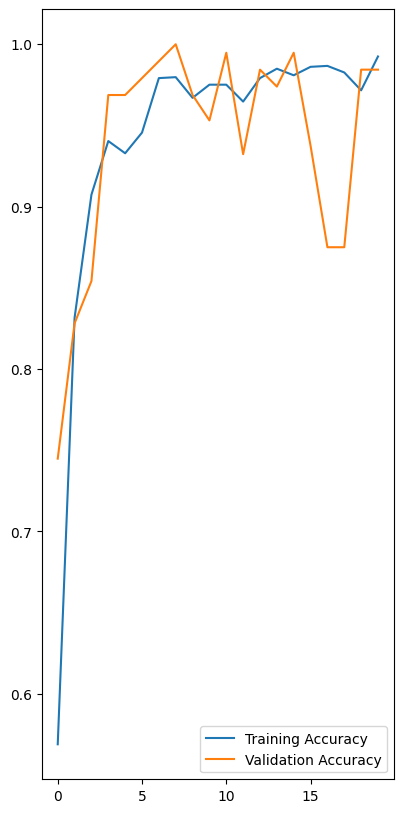

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy")
plt.legend(loc="lower right")

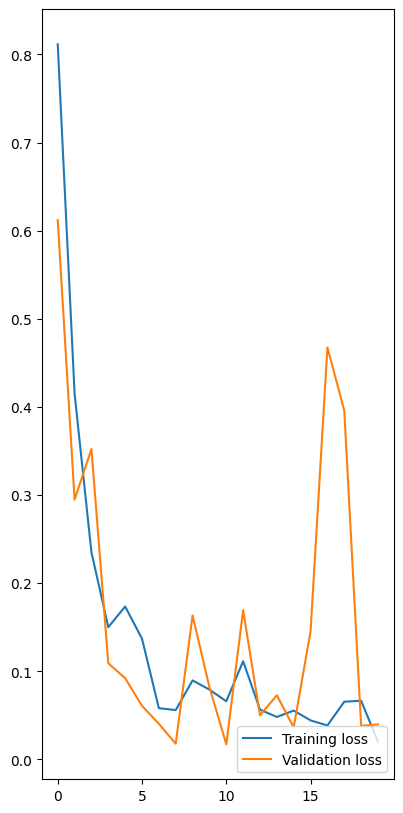

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label="Training loss")
plt.plot(range(EPOCHS),val_loss,label="Validation loss")
plt.legend(loc="lower right")

First image to predict
Actual label: Potato___Late_blight
1/1 [==============================] - 0s 62ms/step
Predicted label: Potato___Late_blight


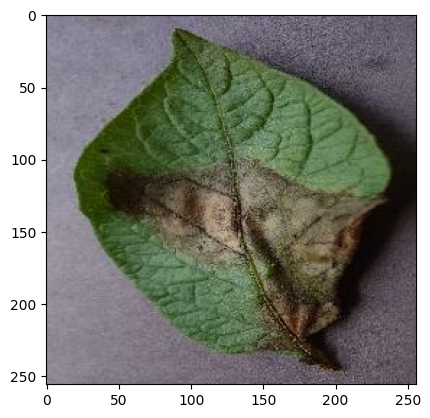

In [ ]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
  first_image=image_batch[0].numpy().astype("uint8")
  first_label=label_batch[0].numpy()

  print("First image to predict")
  plt.imshow(first_image)
  print("Actual label:",classes_names[first_label])

  batch_prediction=model.predict(image_batch)
  print("Predicted label:",classes_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")